<a href="https://colab.research.google.com/github/davidemichelon11/NLU/blob/main/NLU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import numpy as np
from nltk.corpus import movie_reviews
from nltk.corpus import subjectivity

nltk.download('punkt')
nltk.download('vader_lexicon' )
nltk.download('subjectivity')

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import svm

In [3]:
import spacy
spacy.cli.download('en_core_web_lg')
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
def doc2string(doc):
  return " ".join([w for sent in doc for w in sent])

def sent2string(sent):
  return " ".join([w for w in sent])

In [5]:
nltk.download('stopwords')

import unicodedata
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

stop_words = stopwords.words("english")

def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
  )

def normalizeString(s):
  text_tokens = word_tokenize(s)
  s = [word for word in text_tokens if not word in stop_words and not word in punctuation]
  s = unicodeToAscii(sent2string(s).lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')]

corpus_sub = [normalizeString(sent2string(d[0])) for d in subj_docs] + [normalizeString(sent2string(d[0])) for d in obj_docs]

labels_sub = np.array(['subj'] * len(subj_docs) + ['obj'] * len(obj_docs))
train_samples_sub, test_samples_sub, train_labels_sub, test_labels_sub = train_test_split(corpus_sub, labels_sub, test_size=0.3)


**Baselines for subjectivity/objectivity detection**

Two models have been used:


1.   *Naive Bayes Classifier*
2.   *Support Vector Machine*





In [8]:
# Multinomial Naive Bayes and NB and SVM for subj
classifier_NB_subj = MultinomialNB()
classifier_SVM_subj = svm.SVC()
vectorizer_sub = CountVectorizer()

vectors = vectorizer_sub.fit_transform(train_samples_sub + test_samples_sub)

#Multinomial Naive Bayes
classifier_NB_subj.fit(vectors[:len(train_samples_sub)], train_labels_sub)
labels_pred_NB = classifier_NB_subj.predict(vectors[len(train_labels_sub):])
print(classification_report(test_labels_sub, labels_pred_NB, digits=3))

#SVM
classifier_SVM_subj.fit(vectors[:len(train_samples_sub)], train_labels_sub)
labels_pred_SVM = classifier_SVM_subj.predict(vectors[len(train_labels_sub):])
print(classification_report(test_labels_sub, labels_pred_SVM, digits=3))

              precision    recall  f1-score   support

         obj      0.922     0.893     0.908      1529
        subj      0.893     0.922     0.907      1471

    accuracy                          0.907      3000
   macro avg      0.908     0.908     0.907      3000
weighted avg      0.908     0.907     0.907      3000

              precision    recall  f1-score   support

         obj      0.863     0.895     0.879      1529
        subj      0.886     0.852     0.869      1471

    accuracy                          0.874      3000
   macro avg      0.875     0.874     0.874      3000
weighted avg      0.874     0.874     0.874      3000



In [9]:
nltk.download('movie_reviews')
mr = movie_reviews
neg = mr.paras(categories='neg')
pos = mr.paras(categories='pos')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


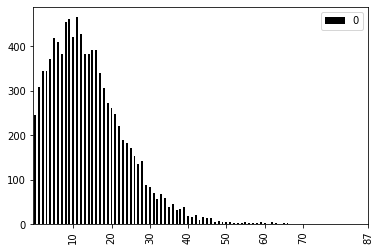

In [10]:
# ! pip install dataframe-image
#distribution of word_length
import pandas
from collections import Counter

lis = []
tokens = 0

for rev in (subj_docs + obj_docs):
  lis.append(len(rev[0]))

lis.sort()
letter_counts = Counter(lis)

i=0
lis = set(lis)
x_values = []
for x in lis:
  if i % 10 == 0:
    x_values.append(x)
  i=i+1

df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar', color='Black', xticks=x_values)

**Baselines for Seniment Analysis**

In [11]:
vectorizer_sa = CountVectorizer()
classifier_sa = svm.SVC()

#each element is the review converted to string
corpus_sa = [normalizeString(doc2string(p)) for p in pos] + [normalizeString(doc2string(n)) for n in neg]

labels_sa = np.array([0] * len(pos) + [1] * len(neg))
train_samples_sa, test_samples_sa, train_labels_sa, test_labels_sa = train_test_split(corpus_sa, labels_sa, test_size=0.1)

In [12]:
#SVM with objective sentences. 73%
vectors = vectorizer_sa.fit_transform(train_samples_sa + test_samples_sa)
classifier_sa.fit(vectors[:len(train_samples_sa)], train_labels_sa)
labels_pred = classifier_sa.predict(vectors[len(train_labels_sa):])

print(classification_report(test_labels_sa, labels_pred, digits=3))

              precision    recall  f1-score   support

           0      0.856     0.856     0.856       104
           1      0.844     0.844     0.844        96

    accuracy                          0.850       200
   macro avg      0.850     0.850     0.850       200
weighted avg      0.850     0.850     0.850       200



In [13]:
def remove_obj_sentences(reviews, vectorizer_sub):
  new_list = []
  for rev in reviews:
    new_rev = []
    for s in rev:
      vector = vectorizer_sub.transform([sent2string(s)]).toarray()
      if classifier_NB_subj.predict(vector) == ['subj']: 
        new_rev.append(s)
    new_list.append(new_rev)
  return new_list

In [14]:
# SVM without obj sentences --> circa 80-82% accuracy
# For each review, remove obj sentences and compute the SVM
vectorizer_sa_subj = CountVectorizer()
classifier_SVM_subj = svm.SVC()

new_pos = remove_obj_sentences(pos, vectorizer_sub)
new_neg = remove_obj_sentences(neg, vectorizer_sub)

corpus_sa_subj = [normalizeString(doc2string(p)) for p in new_pos] + [normalizeString(doc2string(n)) for n in new_neg]

labels_sa_subj = np.array([0] * len(new_pos) + [1] * len(new_neg))
train_samples_, test_samples_, train_labels_, test_labels_ = train_test_split(corpus_sa_subj, labels_sa_subj, test_size=0.2)

vectors_ = vectorizer_sa_subj.fit_transform(train_samples_ + test_samples_)
classifier_SVM_subj.fit(vectors_[:len(train_samples_)], train_labels_)
labels_pred_ = classifier_SVM_subj.predict(vectors_[len(train_labels_):])

print(classification_report(test_labels_, labels_pred_, digits=3))

              precision    recall  f1-score   support

           0      0.809     0.862     0.835       196
           1      0.859     0.804     0.830       204

    accuracy                          0.833       400
   macro avg      0.834     0.833     0.832       400
weighted avg      0.834     0.833     0.832       400



**VADER Baseline**

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

In [16]:
# Analyse complete review
analyzer = SentimentIntensityAnalyzer()
labels_vader = np.array([0] * len(neg) + [1] * len(pos))
prediction_val = [analyzer.polarity_scores(doc2string(v)) for v in (pos + neg)]
prediction_labels = [0 if p['pos'] > p['neg'] else 1 for p in prediction_val]

print(classification_report(labels_sa, prediction_labels, digits=3))

              precision    recall  f1-score   support

           0      0.583     0.842     0.689      1000
           1      0.715     0.397     0.511      1000

    accuracy                          0.620      2000
   macro avg      0.649     0.619     0.600      2000
weighted avg      0.649     0.620     0.600      2000



In [17]:
# Analyse each sentence of review, sum sentences contribution as 1
prediction_labels = []

for rev in (pos+neg):
  pos_ = 0
  neg_ = 0
  for sent in rev:
    p = analyzer.polarity_scores(" ".join([w for w in sent]))
    if p['pos'] > p['neg']: pos_ += 1
    else: neg_ += 1
  prediction_labels.append(0 if pos_ > neg_ else 1)
print(classification_report(labels_sa, prediction_labels, digits=3))

prediction_labels = []

for rev in (pos+neg):
  pos_ = 0
  neg_ = 0
  for sent in rev:
    p = analyzer.polarity_scores(" ".join([w for w in sent]))
    if p['pos'] > p['neg']: pos_ += p['pos']
    else: neg_ += p['neg']
  prediction_labels.append(0 if pos_ > neg_ else 1)
print(classification_report(labels_sa, prediction_labels, digits=3))

              precision    recall  f1-score   support

           0      0.698     0.500     0.583      1000
           1      0.611     0.784     0.687      1000

    accuracy                          0.642      2000
   macro avg      0.654     0.642     0.635      2000
weighted avg      0.654     0.642     0.635      2000

              precision    recall  f1-score   support

           0      0.602     0.843     0.702      1000
           1      0.738     0.442     0.553      1000

    accuracy                          0.642      2000
   macro avg      0.670     0.642     0.628      2000
weighted avg      0.670     0.642     0.628      2000



**Objectivity detection using LSTM**

In [18]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [19]:
batch_size = 120
seq_len = 50
word_embedding = 300
epochs = 10
learning_rate = 0.01
n_hidden = 128
n_categories = 2

In [20]:
class Db(data.Dataset):
  def __init__(self, rev, labels):
    self.rev = rev
    self.labels = labels

  def __len__(self):
    return len(self.rev)

  def __getitem__(self, idx: int):
    return torch.tensor(self.rev[idx]), torch.tensor(self.labels[idx])

In [21]:
def create_tens(rev, seq_len, word_embedding):
  
  rev = word_tokenize(rev)
  if len(rev) > seq_len: 
    rev = rev[:seq_len]

  sent = []
  for i, w in enumerate(rev):
    vector = nlp.vocab[w].vector
    sent.append(vector.tolist())
  
  z = list(np.zeros(word_embedding, dtype=np.float32))
  zs = [z for each in range(seq_len - len(sent))]
  return zs + sent

In [22]:
labels = np.append(np.zeros((len(subj_docs)), dtype=int), np.ones((len(subj_docs)), dtype=int))
# corpus = [sent2string(d[0]).lower() for d in subj_docs] + [sent2string(d[0]).lower() for d in obj_docs]

train_samples, test_samples, train_labels, test_labels = train_test_split(corpus_sub, labels, test_size=0.3)

train_samples = [create_tens(rev, seq_len, word_embedding) for rev in train_samples]
test_samples = [create_tens(rev, seq_len, word_embedding) for rev in test_samples]

# train samples are tensors of seq_len x word_embedding
train_dataset = Db(train_samples, train_labels)
test_dataset = Db(test_samples, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [23]:
# training
def train(model, optimizer, train_loader, e):

  cumulative_accuracy = 0
  samples=0
  pbar = tqdm(train_loader)
  for x,y in pbar:
    x = x.to(device)
    y = y.to(device)
    outputs = model(x)
    loss = criterion(outputs, y.long())
    _, predicted = outputs.max(1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    samples += x.shape[0]
    cumulative_accuracy += predicted.eq(y).sum().item()
    pbar.set_description('Epoch {}/{}, Train accuracy: {:.2f}'.format(e+1,epochs, cumulative_accuracy/samples*100))
  return cumulative_accuracy/samples*100

In [24]:
def evaluate(model, test_loader):

  cumulative_accuracy = 0
  samples=0
  pbar = tqdm(test_loader)
  for x,y in pbar:
    x = x.to(device)
    y = y.to(device)

    outputs = model(x)
    loss = criterion(outputs, y.long())
    _, predicted = outputs.max(1)
    samples += x.shape[0]
    cumulative_accuracy += predicted.eq(y).sum().item()
    pbar.set_description('Evaluate accuracy: {:.2f}'.format(cumulative_accuracy/samples*100))
  return cumulative_accuracy/samples*100

In [34]:
# accuracy on SA: 73%
class LSTM_2(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM_2, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.i2h = nn.LSTM(input_size, hidden_size, dropout = 0.5, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.leaky_ReLU = nn.LeakyReLU(0.1)
    self.i2o = nn.Linear(2*hidden_size, output_size)
      
  def forward(self, input, hidden=None, cell=None):
    if hidden==None:
      hidden = self.init_hidden(input.shape[0])
    if cell==None:
      cell = self.init_hidden(input.shape[0])

    output, (_,_)= self.i2h(input, (hidden,cell))
    output = self.dropout(output)
    output = self.i2o(output)
    output = self.leaky_ReLU(output)
    output = output[:, -1]
    return output

  def init_hidden(self,shape=1):
    return torch.zeros(2, shape, self.hidden_size).to(device)
    
  def init_cell(self,shape=1):
    return torch.zeros(2, shape, self.hidden_size).to(device)
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.i2h = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.i2o = nn.Linear(hidden_size, output_size)
      
  def forward(self, input, hidden=None, cell=None):
    if hidden==None:
      hidden = self.init_hidden(input.shape[0])
    if cell==None:
      cell = self.init_hidden(input.shape[0])

    output, (_,_)= self.i2h(input, (hidden,cell))
    output = self.dropout(output)
    output = self.i2o(output)
    output = output[:, -1]
    return output

  def init_hidden(self,shape=1):
    return torch.zeros(1, shape, self.hidden_size)
    
  def init_cell(self,shape=1):
    return torch.zeros(1, shape, self.hidden_size)

In [ ]:
# around 90% LSTM for subj/obj
lstm = LSTM(word_embedding, n_hidden, n_categories).to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr = 3e-4)

evaluate(lstm, test_loader)

for e in range(epochs):
  train(lstm, optimizer, train_loader, e)

evaluate(lstm, test_loader)

**Sentiment Analysis with LSTM**

In [26]:
batch_size = 100
seq_len = 300

# corpus_sa_subj contains only subjectivity
train_samples_sa_subj, test_samples_sa_subj, train_labels_sa_subj, test_labels_sa_subj = train_test_split(corpus_sa_subj, labels_sa_subj, test_size=0.3, shuffle=True)

train_samples_sa_subj = [create_tens(x, seq_len, word_embedding) for x in train_samples_sa_subj]
test_samples_sa_subj = [create_tens(x, seq_len, word_embedding) for x in test_samples_sa_subj]

train_dataset_sa_subj = Db(train_samples_sa_subj, train_labels_sa_subj)
test_dataset_sa_subj = Db(test_samples_sa_subj, test_labels_sa_subj)

train_loader_sa_subj = torch.utils.data.DataLoader(train_dataset_sa_subj, batch_size=batch_size, shuffle=True)
test_loader_sa_subj = torch.utils.data.DataLoader(test_dataset_sa_subj, batch_size=batch_size, shuffle=True)

In [30]:
n_hidden = 128

lstm_sa = LSTM(word_embedding, n_hidden, n_categories)
optimizer = torch.optim.Adam(lstm_sa.parameters(), lr = 3e-3, weight_decay=0.001)
evaluate(lstm_sa, test_loader_sa_subj)

for e in range(epochs):
  train(lstm_sa, optimizer, train_loader_sa_subj, e)
  evaluate(lstm_sa, test_loader_sa_subj)

evaluate(lstm_sa, test_loader_sa_subj)

Evaluate accuracy: 70.00: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


70.0

In [ ]:
# try different LSTM arch
lstm_sa_2 = LSTM_2(word_embedding, n_hidden, n_categories)
optimizer = torch.optim.Adam(lstm_sa_2.parameters(), lr = 3e-3, weight_decay=0.001)
evaluate(lstm_sa_2, test_loader_sa_subj)

for e in range(epochs):
  train(lstm_sa_2, optimizer, train_loader_sa_subj, e)
  evaluate(lstm_sa_2, test_loader_sa_subj)

evaluate(lstm_sa_2, test_loader_sa_subj)

Experiments:
- remove stop words and punctuation
- add Sigmoid and 2 more linear layers
- try with different sequence length
- try with corpus_sa and not corpus_sa_subj: accuracy very bad
- Add bidirectional=true in LSTM: first dim of hidden and cell is 2 (instead 1) and self.i2o = nn.Linear(2*hidden_size, 64): 79%
- Add a GRU level: 80% con 10 epochs (vedi modello sotto) 
- Tried RELU + 3 linear linear with 40 epochs 75-80%

**Importing pre-trained DistilBERT model and tokenizer**

**Fine-tune BERT Model for Sentiment Analysis in Google Colab**
https://www.analyticsvidhya.com/blog/2021/12/fine-tune-bert-model-for-sentiment-analysis-in-google-colab/

https://www.youtube.com/watch?v=8N-nM3QW7O0

Papers to cite: Attention is all you need and BERT: pre-training of Deep Bidirectional transformers for Language understanding
BERT is bidirectional transformer
BERT can be easily fine-tuned to the task


In [ ]:
!pip3 install transformers

In [ ]:
# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

#Base instead large. Cased considers upper vs lower, uncased not
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [ ]:
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      truncation=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 512
EPOCHS = 10
lr=2e-5
categories = 2


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    #returns the last hidden state (_) and the pooled output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
def  create_data_loader(reviews, targets, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=reviews,
    targets=targets,
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(ds,batch_size=batch_size,num_workers=2)

corpus_sa_subj = [normalizeString(doc2string(p)) for p in pos] + [normalizeString(doc2string(n)) for n in neg]

train_data, test_data, train_labels, test_labels = train_test_split(corpus_sa_subj, labels_sa_subj)

train_data_loader = create_data_loader(train_data, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model = SentimentClassifier(categories).to(device)

In [ ]:
def get_optimizer(model, lr, wd=None, momentum=None, opt='Adam'):
  if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  elif opt == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

In [ ]:
optimizer = get_optimizer(model, lr)
total_steps = len(train_data_loader) * EPOCHS

#As in the paper: the lr decreases linearly from the initial lr set in the optimizer to 0
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()
  losses = []
  correct_predictions = 0
  samples=0
  pbar = tqdm(data_loader)
  for d in pbar:
    # thanks to dataloader, data are aggregated
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    # to avoid exploding gradient
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    samples += len(d["targets"])
    pbar.set_description('Train loss {:.2f} accuracy {:.2f}'.format(np.mean(losses), correct_predictions.double() / samples))

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()
  losses = []
  correct_predictions = 0
  samples = 0
  pbar = tqdm(data_loader)

  with torch.no_grad():
    for d in pbar:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
      samples += len(d["targets"])
      pbar.set_description('Train loss {:.2f} accuracy {:.2f}'.format(np.mean(losses), correct_predictions.double() / samples))

In [ ]:
# Test on different MAX_LENGTH improves
# tried simpler without DataLoader and Dataset but RAM out of memory
# with MAX_LENGTH: 350 --> 83.4%
#with MAX_LENGTH: 450 and no puctuation --> 86.6 %
#with MAX_LENGTH: 512 and no puctuation --> 87.4 %
#with MAX_LENGTH: 512, no puctuation and uncasted --> 89 %
#with MAX_LENGTH: 512, no puctuation, uncasted and corpus_with_objective(pos + neg) --> 
%%time 
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler
  )

  test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device
  )

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

In [ ]:
import matplotlib.pyplot as plt

plt.plot([s.item() for s in history['train_acc']], label='train accuracy')
plt.plot([s.item() for s in history['test_acc']], label='test accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);